In [1]:
import numpy as np
import tt
from tt.amen import amen_solve
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from mpl_toolkits import mplot3d

# Diffusion equation
We need to solve the diffusion equation:

$\frac{\partial}{\partial t} c(x,t) - D \frac{{\partial}^2}{\partial x^2} c(x,t) = 0 $

With conditions $c(x, 0) = \frac{1}{\sqrt{2 \pi}} e^{\frac{x}{2}}$ and $c(5, t) = c(-5, t) = 0$.


## Solution using ordinary method

In [2]:
def solver_FE_simple(I, a, x_0, L, Nx, F, T):
    """
    Simplest expression of the computational algorithm
    using the Forward Euler method and explicit Python loops.
    For this method F <= 0.5 for stability.
    """

    x = np.linspace(x_0, L, Nx+1)   # mesh points in space
    dx = x[1] - x[0]
    dt = F*dx**2/a
    print(dt)
    Nt = int(round(T/float(dt)))
    t = np.linspace(0, T, Nt+1)   # mesh points in time
    u   = np.zeros(Nx+1)
    u_1 = np.zeros(Nx+1)

    # Set initial condition u(x,0) = I(x)
    for i in range(0, Nx+1):
        u_1[i] = I(x[i])

    for n in tqdm(range(0, Nt)):
        # Compute u at inner mesh points
        for i in range(1, Nx):
            u[i] = u_1[i] + F*(u_1[i-1] - 2*u_1[i] + u_1[i+1])

        # Insert boundary conditions
        u[0] = 0;  u[Nx] = 0

        # Switch variables before next step
        u_1, u = u, u_1
        #print(u[int(u.shape[0] / 2)] - u_1[int(u.shape[0] / 2)])

    return u, x


In [3]:
def gauss_func(x, mu=0.5, sigma=0.05):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma)**2) 

In [4]:
START_X = 0
END_X = 1
END_t = 0.1
F = 0.5
NX = 100
D = 1
STEP = F*0.01**2/D


5e-05


  0%|          | 0/1 [00:00<?, ?it/s]

5e-05


  0%|          | 0/101 [00:00<?, ?it/s]

5e-05


  0%|          | 0/201 [00:00<?, ?it/s]

5e-05


  0%|          | 0/301 [00:00<?, ?it/s]

5e-05


  0%|          | 0/401 [00:00<?, ?it/s]

5e-05


  0%|          | 0/501 [00:00<?, ?it/s]

5e-05


  0%|          | 0/601 [00:00<?, ?it/s]

5e-05


  0%|          | 0/701 [00:00<?, ?it/s]

5e-05


  0%|          | 0/801 [00:00<?, ?it/s]

5e-05


  0%|          | 0/901 [00:00<?, ?it/s]

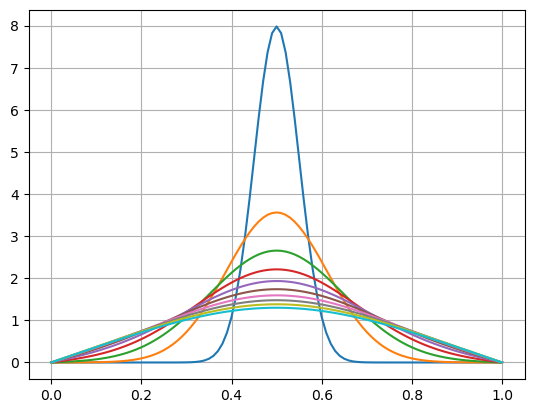

In [5]:
for i in range(1, 1000, 100):
    u, x = solver_FE_simple(gauss_func, D, START_X, END_X, NX, F, STEP * i)
    plt.plot(x, u)
plt.grid()
plt.show()

## Conclusion:

As wee see this method actually works, however, it's too time- and memory-demanding with $D=10^{-5}$ to get results. It took practically 1 minute to get result only for 1 time. To get results for each time we will need a lot of memory to store 

## 1. Creating equation in TT-format

Our boundaries will be $[-5, 5] \times [0, 100]$

In [6]:
d_x = 7
d_t = 16
START_X = -5
END_X = 5
START_t = 0
END_t = 10**6
shift_x = tt.qshift(d_x)
eye_x = tt.eye(2, d_x)
shift_t = tt.qshift(d_t)
eye_t = tt.eye(2, d_t)
delta_x = (END_X - START_X) / (2 ** d_x -1)
delta_t = (END_t - START_t) / (2 ** d_t - 1)
D = 10**(-5)
mu = 0
sigma = 1

In [7]:
0.1 * (delta_x**2) / D
print(delta_t, delta_x, delta_t * D / (delta_x)**2 )

15.259021896696423 0.07874015748031496 0.024611276417181662


In [8]:
#Differential operator
dif_op_x = shift_x - shift_x.T
#Laplace operator
laplace_x = shift_x + shift_x.T - 2 * eye_x
#Differential operator
dif_op_t = eye_t - shift_t.T
#Laplace operator
laplace_t = shift_t + shift_t.T - 2 * eye_t

In [9]:
def gauss_func(x, mu, sigma):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma)**2) 

In [10]:
#Matrix A and b
A =  tt.kron(eye_x, dif_op_t) - D * delta_t / (delta_x**2) * tt.kron(laplace_x, eye_t)
right_part = np.zeros(2 ** (d_x + d_t))
right_part[0:2**d_x] = gauss_func(np.linspace(START_X, END_X, 2**d_x), mu, sigma)
b = tt.vector(right_part.reshape([2] * (d_x + d_t), order='F'))

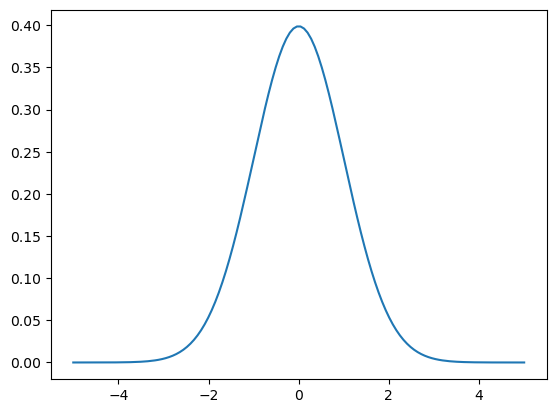

In [11]:
X = np.linspace(START_X, END_X, 2**d_x)
plt.plot(X, b.full().flatten('F')[:2**d_x])
plt.show()

## Equation solution

We will use AMEN algorithm to solve diffusion equation

In [12]:
result = amen_solve(A, b, b, 1e-6)

amen_solve: swp=1, max_dx= 7.071E-01, max_res= 9.999E-01, max_rank=11
amen_solve: swp=2, max_dx= 3.605E-01, max_res= 6.627E+00, max_rank=10
amen_solve: swp=3, max_dx= 5.291E-02, max_res= 6.457E-01, max_rank=14
amen_solve: swp=4, max_dx= 3.081E-03, max_res= 1.417E-01, max_rank=17
amen_solve: swp=5, max_dx= 2.235E-04, max_res= 4.192E-03, max_rank=21
amen_solve: swp=6, max_dx= 5.947E-06, max_res= 4.257E-04, max_rank=25
amen_solve: swp=7, max_dx= 8.763E-07, max_res= 8.980E-06, max_rank=24
amen_solve: swp=8, max_dx= 2.961E-07, max_res= 2.537E-06, max_rank=20
amen_solve: swp=9, max_dx= 1.355E-07, max_res= 3.585E-06, max_rank=18
amen_solve: swp=10, max_dx= 5.986E-08, max_res= 2.234E-06, max_rank=18
amen_solve: swp=11, max_dx= 2.694E-07, max_res= 1.315E-06, max_rank=18
amen_solve: swp=12, max_dx= 8.488E-08, max_res= 1.635E-06, max_rank=18
amen_solve: swp=13, max_dx= 7.365E-08, max_res= 2.110E-06, max_rank=21
amen_solve: swp=14, max_dx= 4.019E-08, max_res= 2.193E-06, max_rank=18
amen_solve: swp

In [13]:
C = result.full().flatten('F')
C.shape

(8388608,)

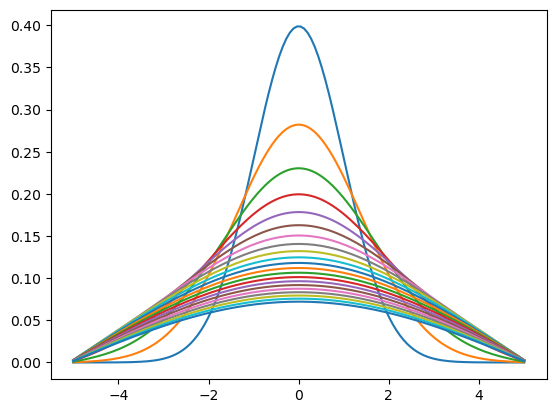

In [14]:
i=0
X = np.linspace(START_X, END_X, 2**d_x)
Y = C[2**d_x * i: 2**d_x * (i+1)]
for i in range (0, 2**d_t, int(2**d_t / 20)):  
    plt.plot(X, C[2**d_x * i: 2**d_x * (i+1)])
plt.show()

## Results:
We got expected results with high accuracy. The main advantage of this method over ordinary is speed, AMEN worked less then 1 sec. 

# 2-dimensional diffusion equation

$\frac{\partial}{\partial t} c(t, x, y) - D (\frac{{\partial}^2}{\partial x^2} c(t, x, y) + \frac{{\partial}^2}{\partial y^2} c(t, x, y)) = 0 $

With conditions $c(0, x, y) = 2d \ gaussian$ and $c(t, 1, y) = c(t, -1, y) = c(t, x, 1) = c(t, x, -1) = 0$.

In [14]:
def func(x, y, mu =np.array([0,0]), cov_matrix = 10 * np.eye(2)):
    X = np.array([x, y])
    return 1 / ((2 * np.pi)**(2/2) * (np.linalg.det(cov_matrix))**(1/2)) * \
    np.exp(-0.5 * (X - mu).T @ cov_matrix @ (X - mu))

In [92]:
#Set conditions and parameters. Mention that we don't set parameters for y due to symmetry of x and y.
d_x = 4
d_t = 6
START_X = -1
END_X = 1
START_t = 0
END_t = 10**4
shift_x = tt.qshift(d_x)
eye_x = tt.eye(2, d_x)
shift_t = tt.qshift(d_t)
eye_t = tt.eye(2, d_t)
delta_x = (END_X - START_X) / (2 ** d_x -1)
delta_t = (END_t - START_t) / (2 ** d_t - 1)
D = 10**(-5)


In [93]:
#Differential operator
dif_op_x = shift_x - shift_x.T
#Laplace operator
laplace_x = shift_x + shift_x.T - 2 * eye_x
#Differential operator
dif_op_t = eye_t - shift_t.T
#Laplace operator
laplace_t = shift_t + shift_t.T - 2 * eye_t

In [94]:
#Matrix A and b
A =  tt.kron(tt.kron(eye_x, eye_x), dif_op_t) - D * delta_t / (delta_x**2) * (tt.kron(tt.kron(eye_x, laplace_x), eye_t) \
                                                                              + tt.kron(tt.kron(laplace_x, eye_x), eye_t))
right_part = np.zeros(2 ** (2 * d_x + d_t))
X = np.linspace(START_X, END_X, 2**d_x)
for i in range(2**d_x):
    for j in range(2**d_x):
        right_part[2**d_x * i + j] = func(X[i], X[j])
b = tt.vector(right_part.reshape([2] * (2*d_x + d_t), order='F'))

In [95]:
b.full().flatten('F')[:2**(d_x * 2)].reshape((2**d_x, 2**d_x)).shape
X.shape

(16,)

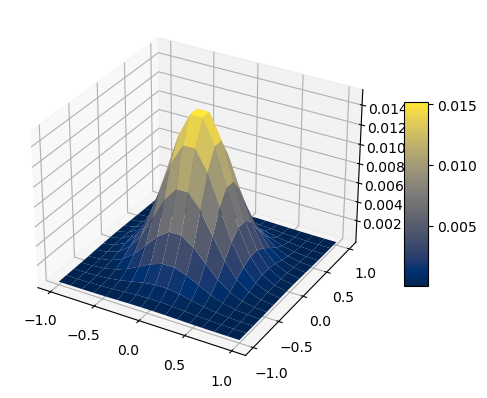

In [96]:
x, y = np.meshgrid(X, X)
fig = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(x, y, b.full().flatten('F')[:2**(d_x * 2)].reshape((2**d_x, 2**d_x)).T, cmap = plt.cm.cividis)

fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

In [97]:
result = amen_solve(A, b, b, 1e-6)

amen_solve: swp=1, max_dx= 7.018E-01, max_res= 9.851E-01, max_rank=8
amen_solve: swp=2, max_dx= 1.883E-01, max_res= 3.133E-01, max_rank=12
amen_solve: swp=3, max_dx= 1.267E-03, max_res= 2.375E-03, max_rank=16
amen_solve: swp=4, max_dx= 8.896E-06, max_res= 2.060E-05, max_rank=20
amen_solve: swp=5, max_dx= 1.384E-07, max_res= 7.193E-07, max_rank=24


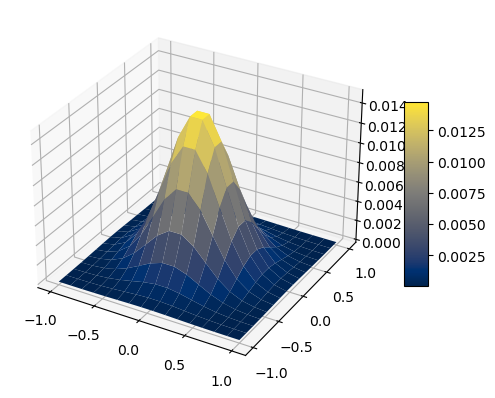

In [98]:
i = 0
x, y = np.meshgrid(X, X)
fig = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(x, y, result.full().flatten('F')[i * 2**(d_x * 2): (i + 1) * 2**(d_x * 2)].reshape((2**d_x, 2**d_x)).T, cmap = plt.cm.cividis)
ax.axes.set_zlim3d(bottom=0, top=0.015)
fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

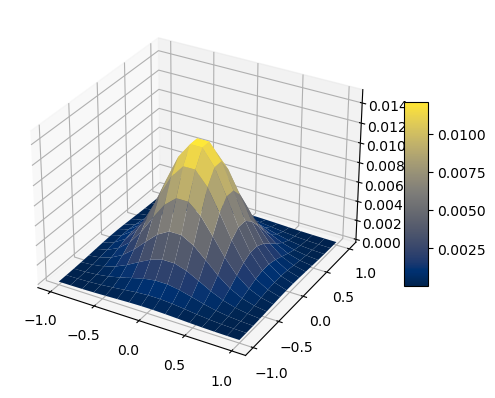

In [106]:
i = 8
x, y = np.meshgrid(X, X)
fig = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(x, y, result.full().flatten('F')[i * 2**(d_x * 2): (i + 1) * 2**(d_x * 2)].reshape((2**d_x, 2**d_x)).T, cmap = plt.cm.cividis)
ax.axes.set_zlim3d(bottom=0, top=0.015)
fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

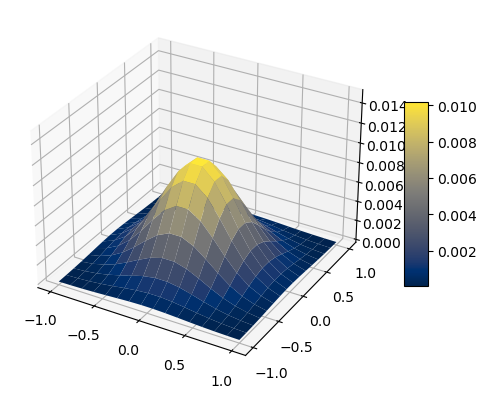

In [107]:
i = 16
x, y = np.meshgrid(X, X)
fig = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(x, y, result.full().flatten('F')[i * 2**(d_x * 2): (i + 1) * 2**(d_x * 2)].reshape((2**d_x, 2**d_x)).T, cmap = plt.cm.cividis)
ax.axes.set_zlim3d(bottom=0, top=0.015)
fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

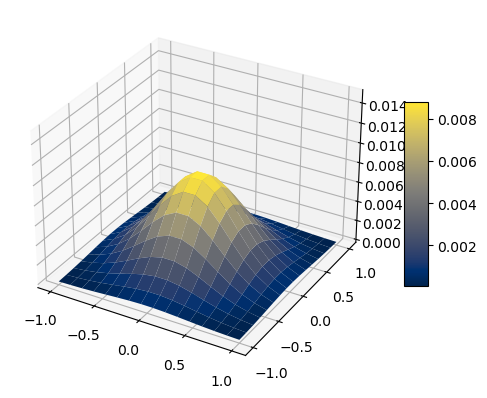

In [108]:
i = 24
x, y = np.meshgrid(X, X)
fig = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(x, y, result.full().flatten('F')[i * 2**(d_x * 2): (i + 1) * 2**(d_x * 2)].reshape((2**d_x, 2**d_x)).T, cmap = plt.cm.cividis)
ax.axes.set_zlim3d(bottom=0, top=0.015)
fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

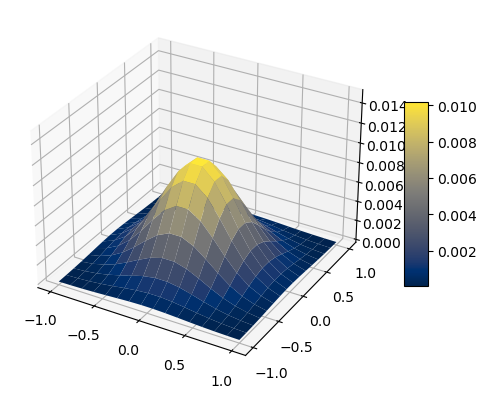

In [102]:
i = 16
x, y = np.meshgrid(X, X)
fig = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(x, y, result.full().flatten('F')[i * 2**(d_x * 2): (i + 1) * 2**(d_x * 2)].reshape((2**d_x, 2**d_x)).T, cmap = plt.cm.cividis)
ax.axes.set_zlim3d(bottom=0, top=0.015)
fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

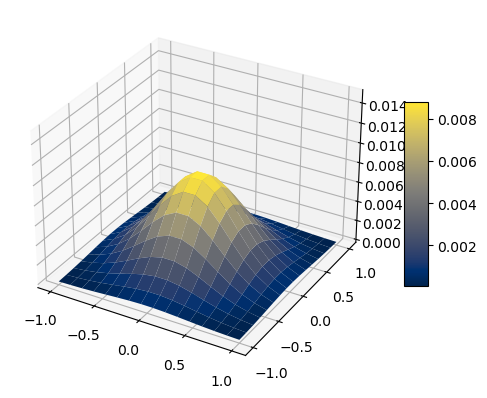

In [109]:
i = 24
x, y = np.meshgrid(X, X)
fig = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(x, y, result.full().flatten('F')[i * 2**(d_x * 2): (i + 1) * 2**(d_x * 2)].reshape((2**d_x, 2**d_x)).T, cmap = plt.cm.cividis)
ax.axes.set_zlim3d(bottom=0, top=0.015)
fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

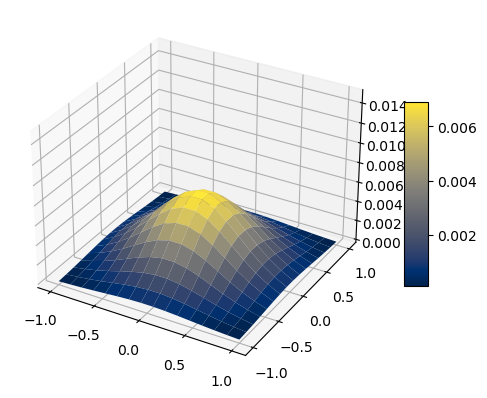

In [111]:
i = 40
x, y = np.meshgrid(X, X)
fig = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(x, y, result.full().flatten('F')[i * 2**(d_x * 2): (i + 1) * 2**(d_x * 2)].reshape((2**d_x, 2**d_x)).T, cmap = plt.cm.cividis)
ax.axes.set_zlim3d(bottom=0, top=0.015)
fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

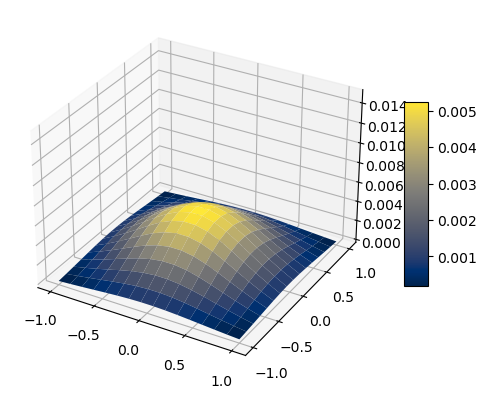

In [112]:
i = 63
x, y = np.meshgrid(X, X)
fig = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(x, y, result.full().flatten('F')[i * 2**(d_x * 2): (i + 1) * 2**(d_x * 2)].reshape((2**d_x, 2**d_x)).T, cmap = plt.cm.cividis)
ax.axes.set_zlim3d(bottom=0, top=0.015)
fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

## Results:
Again as in 1d case we got expected results. The main difference is that we need to pay a lot of attention to number of cores in each dimension because the vector of function will contain $2^{\sum d_i}$ elemenrs, and it's size should be less that $2^{16}$, otherwise the kernel will crush.